In [ ]:
## Setting up
import numpy as np
import csv, os
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import torch
import matplotlib.pyplot as plt
from clusim.clustering import Clustering
import clusim.sim as sim
import seaborn as sns

In [ ]:
## Setting the environment
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
## PCA and SPA Model (Modified)
## These models are derived from the orignial paper but modified.
def pca_torch(X_norm, k):
    X = torch.from_numpy(X_norm).to(device)
    xMat = X.t()
    Z = -(xMat.t() @ xMat)
    eigVals, eigVecs = torch.linalg.eigh(Z)
    Q = eigVecs[:, :k]
    Y = xMat @ Q
    return Y.cpu().numpy()

def spca_torch(X_norm, beta, k, iters=10):
    X = torch.from_numpy(X_norm).to(device)
    xMat = X.t()
    vMat = torch.eye(X.size(0), device=device)
    for _ in range(iters):
        Z = -(xMat.t() @ xMat) + beta * vMat
        eigVals, eigVecs = torch.linalg.eigh(Z)
        Q = eigVecs[:, :k]
        norms = torch.norm(Q, dim=1)
        vMat = torch.diag(1.0/(2.0*norms))
    Y = xMat @ Q
    return Y.cpu().numpy()

In [ ]:
## Codes for clustering, clustering score, and element censtric score
## Also derived from the original paper

def computeKMeans(X, y, max_state = 30):
    '''
        compute k-means clustering for the reduction with 30 random instance
        input:
            X: M x N data
            y: M * 1 true labels
            max_state: number of k-means state
        return:
            LABELS: max_state * M label from k-means
            ARI: max_state * 1 ari for each instance of k-means
            NMI: max_state * 1 nmi for each instance of k-means
            Sil: max_state * 1 silhouette score for each instance of k-means
    '''
    M = X.shape[0]
    n_clusters = np.unique(y).shape[0]
    X_scaled = StandardScaler().fit_transform(X)
    LABELS = np.zeros([max_state, M])
    ARI = np.zeros(max_state); NMI = np.zeros(max_state); ECS = np.zeros(max_state)
    for state in range(max_state):
        myKM = KMeans(n_clusters = n_clusters,  n_init = 150, random_state = state)
        myKM.fit(X_scaled)
        label = myKM.labels_
        ARI[state], NMI[state] = computeClusterScore(y, label)
        ECS[state] = computeElementCenstricScore(y, label)
        LABELS[state, :] = label
    return ARI, NMI, ECS

def computeClusterScore(y, label):
    ari = adjusted_rand_score(y, label)
    nmi = normalized_mutual_info_score(y, label)
    return ari, nmi

def computeElementCenstricScore(y, label):
    clustering1 = Clustering().from_membership_list(y)
    clustering2 = Clustering().from_membership_list(label)
    score = sim.element_sim(clustering1, clustering2, alpha=0.9)
    return score


In [1]:
## KNN-tPCA models from the paper for clustering

import numpy as np
import pandas as pd

def gaussian_kernel(dist, t):
    '''
    gaussian kernel function for weighted edges
    '''
    return np.exp(-(dist**2 / t))

def Eu_dis(x):
    """
    Calculate the distance among each raw of x
    :param x: N X D
                N: number of samples
                D: Dimension of the feature
    :return: N X N distance matrix
    """
    x = np.asarray(x)
    aa = np.sum(np.multiply(x, x), 1)
    ab = x @ x.T
    dist_mat = aa + aa.T - 2 * ab
    dist_mat[dist_mat < 0] = 0
    dist_mat = np.sqrt(dist_mat)
    dist_mat = np.maximum(dist_mat, dist_mat.T)
    dist_mat = np.asarray(dist_mat)
    return dist_mat

def cal_weighted_adj(data, n_neighbors, t):
    '''
    Calculate weighted adjacency matrix based on KNN
    For each row of X, put an edge between nodes i and j
    If nodes are among the n_neighbors nearest neighbors of each other
    according to Euclidean distance
    '''
    dist = Eu_dis(data)
    n = dist.shape[0]
    gk_dist = gaussian_kernel(dist, t)
    W_L = np.zeros((n, n))
    for i in range(n):
        index_L = np.argsort(dist[i, :])[1:1 + n_neighbors]
        len_index_L = len(index_L)
        for j in range(len_index_L):
            W_L[i, index_L[j]] = gk_dist[i, index_L[j]] #weighted edges
    W_L = np.maximum(W_L, W_L.T)
    return W_L

def cal_unweighted_adj(data, n_neighbors):
    '''
    Calculate unweighted adjacency matrix based on KNN
    '''
    dist = Eu_dis(data)
    n = dist.shape[0]
    W_L = np.zeros((n, n))
    for i in range(n):
        index_L = np.argsort(dist[i, :])[1:1 + n_neighbors]
        len_index_L = len(index_L)
        for j in range(len_index_L):
            W_L[i, index_L[j]] = 1 #edges not weighted
    W_L = np.maximum(W_L, W_L.T)
    return W_L

def cal_laplace(adj):
    N = adj.shape[0]
    D = np.zeros_like(adj)
    for i in range(N):
        D[i, i] = np.sum(adj[i]) # Degree Matrix
    L = D - adj  # Laplacian
    return L


def RpLSPCA_Algorithm(xMat,laplace,beta,gamma,k,n):
    '''
    Optimization Algorithm of RgLSPCA / RpLSPCA
    Solve approximately via ADMM
    Need to compute optimal principal directions matrix U
    Projected Data matrix Q
    Error term matrix E = X - UQ^T
    Z matrix used to solve Q (see supplementary information)

    Inputs are data matrix X, laplacian term, scale parameters,
    number of reduced dimensions, number of original dimensions
    '''
    # Initialize thresholds, matrices
    obj1 = 0
    obj2 = 0
    thresh = 1e-50
    V = np.eye(n)
    vMat = np.asarray(V) # Auxillary matrix to optimize L2,1 norm
    E = np.ones((xMat.shape[0],xMat.shape[1]))
    E = np.asarray(E) # Error term X - UQ^T
    C = np.ones((xMat.shape[0],xMat.shape[1]))
    C = np.asarray(C) # Lagrangian Multiplier
    laplace = np.asarray(laplace) #Lplacian
    miu = 1 #Penalty Term
    for m in range(0, 30):
        Z = (-(miu/2) * ((E - xMat + C/miu).T @ (E - xMat + C/miu))) + beta * vMat + gamma * laplace
        # cal Q (Projected Data Matrix)
        Z_eigVals, Z_eigVects = np.linalg.eig(np.asarray(Z))
        eigValIndice = np.argsort(Z_eigVals)
        n_eigValIndice = eigValIndice[0:k]
        n_Z_eigVect = Z_eigVects[:, n_eigValIndice]
        # Optimal Q given by eigenvectors corresponding
        # to smallest k eigenvectors
        Q = np.array(n_Z_eigVect)
        # cal V
        q = np.linalg.norm(Q, ord=2, axis=1)
        qq = 1.0 / (q * 2)
        VV = np.diag(qq)
        vMat = np.asarray(VV)
        qMat = np.asarray(Q)
        # cal U (Principal Directions)
        U = (xMat - E - C/miu) @ qMat
        # cal P (intermediate step)
        P = xMat - U @ qMat.T - C/miu
        # cal E (Error Term)
        for i in range(E.shape[1]):
            E[:,i] = (np.max((1 - 1.0 / (miu * np.linalg.norm(P[:,i]))),0)) * P[:,i]
        # update C
        C = C + miu * (E - xMat + U @ qMat.T)
        # update miu
        miu = 1.2 * miu

        obj1 = np.linalg.norm(qMat)
        if m > 0:
            diff = obj2 - obj1
            if diff < thresh:
                break # end iterations if error within accepted threshold
        obj2 = obj1
    return U #return principal directions matrix


def cal_persistent_laplace(W_L, zetas):
    n = W_L.shape[0]
    np.fill_diagonal(W_L,0)

    L = cal_laplace(W_L)
    #print("Laplace: ", L)

    np.fill_diagonal(L, 1e8) #Make sure diagonal is excluded from maximal and minimal value consideration
    min_l = np.min(L[np.nonzero(L)]) #Establish Min Value
    #print("min: ", min_l)
    np.fill_diagonal(L, -1e8)
    max_l = np.max(L[np.nonzero(L)]) #Establish Max Value
    #print("max: ", max_l)

    d = max_l - min_l
    #print("d: ", d)

    L = cal_laplace(W_L)
    PL = np.zeros((8,n,n))
    for k in range(1,8):
        PL[k,:,:] = np.where(L < (k/7*d + min_l), 1, 0)
        #print("Threshold for k = ", k, ": ", k/7*d + min_l)
        np.fill_diagonal(PL[k,:,:],0)
        PL[k,:,:] = cal_laplace(PL[k,:,:])
        #print(PL[k,:,:])

    P_L = np.sum(zetas[:, np.newaxis, np.newaxis] * PL, axis=0)

    return P_L

def RpLSPCA_cal_projections(X_data, beta1, gamma1, k_d, zetas):
    n = len(X_data)
    dist = Eu_dis(X_data)
    max_dist = np.max(dist)
    W_L = cal_weighted_adj(X_data, n_neighbors=15, t=max_dist**(2))
    A = W_L
    PL = cal_persistent_laplace(A, zetas)
    Y = RpLSPCA_Algorithm(X_data.transpose(), PL, beta1, gamma1, k_d, n)
    return Y

def cal_persistence_KNN(data, n_filtrations, zetas):
    n = data.shape[0]
    '''
    Consider n neighbors and reduce by 2 neighbors at
    each iteration of filtration down to 1 nearest neighbor
    (p filtrations)
    '''
    num_neighbors_list = range(1, n_filtrations + 1, 2)
    num_filtrations = len(num_neighbors_list)

    PL = np.zeros((num_filtrations, n, n))
    zetas = np.array(zetas)

    for idx, num_neighbors in enumerate(num_neighbors_list):
        A = cal_unweighted_adj(data, num_neighbors)
        #print('num neighbors:', num_neighbors)
        PL[idx, :, :] = cal_laplace(A)
        #print("i'th PL:", PL[idx, :, :])

    Persistent_Laplacian = np.sum(zetas[:, np.newaxis, np.newaxis] * PL, axis=0)
    return Persistent_Laplacian

def RpLSPCA_cal_projections_KNN(X_data, beta1, gamma1, k_d, num_filtrations, zeta):
    n = len(X_data)
    M = cal_persistence_KNN(X_data, num_filtrations, zeta)
    Y = RpLSPCA_Algorithm(X_data.transpose(), M, beta1, gamma1, k_d, n)
    return Y

def PCA_Algorithm(xMat,k):
    Z = -(xMat.T @ xMat)
    Z_eigVals, Z_eigVects = np.linalg.eig(Z)
    eigValIndice = np.argsort(Z_eigVals)
    n_eigValIndice = eigValIndice[0:k]
    n_Z_eigVect = Z_eigVects[:, n_eigValIndice]
    Q = np.array(n_Z_eigVect)
    qMat = np.mat(Q)
    Y = xMat * qMat
    return Y

def PCA_cal_projections(X_data,k_d):
    Y = PCA_Algorithm(X_data.T, k_d)
    return Y

def SPCA_Algorithm(xMat,beta,k,n):
    obj1 = 0
    obj2 = 0
    thresh = 1e-50
    V = np.eye(n)
    vMat = np.mat(V)
    for m in range(0, 10):
        Z = -(xMat.T @ xMat) + beta * vMat
        Z_eigVals, Z_eigVects = np.linalg.eig(np.mat(Z))
        eigValIndice = np.argsort(Z_eigVals)
        n_eigValIndice = eigValIndice[0:k]
        n_Z_eigVect = Z_eigVects[:, n_eigValIndice]
        Q = np.array(n_Z_eigVect)
        q = np.linalg.norm(Q, ord=2, axis=1)
        qq = 1.0 / (q * 2)
        VV = np.diag(qq)
        vMat = np.mat(VV)
        qMat = np.mat(Q)
        Y = xMat * qMat
        obj1 = np.linalg.norm(qMat)
        if m > 0:
            diff = obj2 - obj1
            if diff < thresh:
                break
        obj2 = obj1
    return Y

def SPCA_cal_projections(X_data,beta1, k_d):
    n = len(X_data)
    Y= SPCA_Algorithm(X_data.transpose(), beta1, k_d, n)
    return Y

def PCA_Algorithm(xMat,k):
    Z = -(xMat.T @ xMat)
    Z_eigVals, Z_eigVects = np.linalg.eig(Z)
    eigValIndice = np.argsort(Z_eigVals)
    n_eigValIndice = eigValIndice[0:k]
    n_Z_eigVect = Z_eigVects[:, n_eigValIndice]
    Q = np.array(n_Z_eigVect)
    qMat = np.mat(Q)
    Y = xMat * qMat
    return Y

def PCA_cal_projections(X_data,k_d):
    Y = PCA_Algorithm(X_data.T, k_d) #(20502, 643)
    return Y

In [ ]:
## Reading the dataset "GSE72056"

df = pd.read_csv('GSE72056_melanoma_single_cell_revised_v2.txt', sep='\t')
# df.head()

## Setting the dataframes for cell id
## Checking to see if the cell is malignant or nonmalign.
cell_barcodes   = df.columns.tolist()[1:]
malignant_codes = df.iloc[1,1:].astype(int).values
nonmalign_codes = df.iloc[2,1:].astype(int).values

In [ ]:
## Creating a label list
## Unzipping the RAW data
label_list = []

## Checking for malignancy status
for m,nm in zip(malignant_codes, nonmalign_codes):
    # If the “malignant” flag is 2 → definitely malignant
    if m==2:      label_list.append('Malignant')
    # If the “malignant” flag is 0 → couldn’t resolve malignancy status
    elif m==0:    label_list.append('Unresolved')
    else:
        subtype = {0:'Unresolved',1:'T',2:'B',3:'Macro',4:'End',5:'NK',6:'DC'}
        # Look up nm in the dictionary. If it’s missing, label as 'Unknown'
        label_list.append(subtype.get(nm,'Unknown'))

## Covert the list into an array labels
y_all = np.array(label_list)

## Take all rows from the 4th onward as the actual expression data
expr = df.iloc[3:].rename(columns={'Cell':'Gene'})

# Reset the column headers: first column is "Gene", the rest are your cell barcodes
expr.columns = ['Gene'] + cell_barcodes

# Make sure the expression columns are floats (not strings)
expr[cell_barcodes] = expr[cell_barcodes].astype(float)

# Build a raw data matrix of shape (num_cells × num_genes)
# by transposing so that rows are cells and columns are genes
X_raw = expr[cell_barcodes].T.values

In [ ]:
## Since the actual data size 4645 x 23686; this was too big for our server to run.
## Randomly pick 700 cells (set random_state for reproducibility)
## We chose 700 for the reduction because we wanted reduce our data size closer to the one that we replicated (705 x 18840)

np.random.seed(42)
n_pick = 700
idx     = np.random.choice(X_raw.shape[0], n_pick, replace=False)
X_sub   = X_raw[idx]
y_sub   = y_all[idx]

In [ ]:
## Log-transform the data (plus one to avoid log(0))
log_X = np.log1p(X_sub)
## Zero-out any tiny values that didn't get filtered out from the transform
log_X[log_X < 1e-6] = 0

## Compute per-gene variance across cells
vars_g = np.var(log_X, axis=0)

## Filtered out the lowest 25% variance and keep the top 75%
mask_g = vars_g > np.percentile(vars_g, 25)
filtered = log_X[:, mask_g]

## Identify any cell-types with fewer than 15 cells, and filter them out
uniq, counts = np.unique(y_sub, return_counts=True)
to_drop      = uniq[counts < 15]
keep_c       = ~np.isin(y_sub, to_drop)
X_filtered   = filtered[keep_c]
y_filtered   = y_sub[keep_c]

print("After var filter:", filtered.shape,
      "After rare-cell drop:", X_filtered.shape,
      "labels:", np.unique(y_filtered, return_counts=True))


After var filter: (700, 17764) After rare-cell drop: (677, 17764) labels: (array(['B', 'Macro', 'Malignant', 'T', 'Unresolved'], dtype='<U10'), array([ 74,  20, 181, 302, 100]))


In [ ]:
## Z-score each gene or each column across all cells
X_norm = StandardScaler().fit_transform(X_filtered)
print("X_norm.shape:", X_norm.shape)

X_norm.shape: (677, 17764)


## Run the Algorithmn

## KNN_tPCA Clustering

In [ ]:
## Now we are done with the prepossing of the dataset
## We will now work on clustering
zeta = np.array([1.0, 0.5, 0.3333333, 0.25, 0.20, 0.16666667, 0.14285714, 0.125])
PDM_t = RpLSPCA_cal_projections_KNN(X_norm, 60.0, 100000.0, 8, 15, zeta)
PDM_t = np.asarray(PDM_t)
TM_t   = np.linalg.inv(PDM_t.T @ PDM_t) @ (PDM_t.T)
Q_tPCA = X_norm @ TM_t.T

k = len(np.unique(y_filtered))

In [ ]:
ARI_vals, NMI_vals, ECS_vals = computeKMeans(Q_tPCA, y_filtered, max_state=30)

ARI_mean = ARI_vals.mean()
NMI_mean = NMI_vals.mean()
ECS_mean = ECS_vals.mean()

print("=== tPCA + KMeans Clustering Results ===")
print(f"Number of clusters (k): {k}")
print(f"tPCA projection shape: {Q_tPCA.shape}")
print(f"Adjusted Rand Index (mean over 30 inits): {ARI_mean:.4f}")
print(f"Normalized Mutual Info (mean over 30 inits): {NMI_mean:.4f}")
print(f"Element-Centric Score (mean over 30 inits): {ECS_mean:.4f}")


=== tPCA + KMeans Clustering Results ===
Number of clusters (k): 5
tPCA projection shape: (677, 8)
Adjusted Rand Index (mean over 30 inits): 0.3422
Normalized Mutual Info (mean over 30 inits): 0.3896
Element-Centric Score (mean over 30 inits): 0.4279


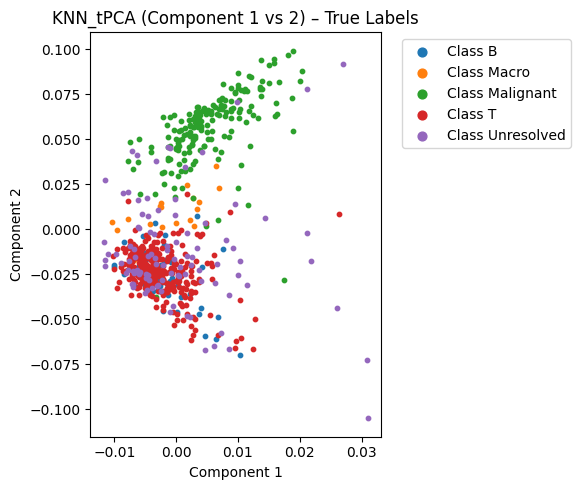

In [ ]:
plt.figure(figsize=(6, 5))
unique_lbls = np.unique(y_filtered)
for lbl in unique_lbls:
    idx = np.where(y_filtered == lbl)[0]
    plt.scatter(Q_tPCA[idx, 0], Q_tPCA[idx, 1], s=10, label=f"Class {lbl}")
plt.title("KNN_tPCA (Component 1 vs 2) – True Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## KNN_sPCA Clustering

In [ ]:
# # We had to manually set beta for sPCA for this project.
# Run sPCA and project
PDM = spca_torch(X_norm, 60, k)
PDM = np.asarray(PDM)

TM = np.linalg.inv(PDM.T @ PDM) @ PDM.T
Q_spca = X_norm @ TM.T


In [ ]:
# K-means / ARI & NMI & ECS
k = len(np.unique(y_filtered))
ARI_vals, NMI_vals, ECS_vals = computeKMeans(Q_spca, y_filtered, max_state=30)

ARI_mean = ARI_vals.mean()
NMI_mean = NMI_vals.mean()
ECS_mean = ECS_vals.mean()

print("=== sPCA + KMeans Clustering Results ===")
print(f"Number of clusters (k): {k}")
print(f"sPCA projection shape: {Q_spca.shape}")
print(f"Adjusted Rand Index (mean over 30 inits): {ARI_mean:.4f}")
print(f"Normalized Mutual Info (mean over 30 inits): {NMI_mean:.4f}")
print(f"Element-Centric Score (mean over 30 inits): {ECS_mean:.4f}")

=== sPCA + KMeans Clustering Results ===
Number of clusters (k): 5
sPCA projection shape: (677, 5)
Adjusted Rand Index (mean over 30 inits): 0.4444
Normalized Mutual Info (mean over 30 inits): 0.4794
Element-Centric Score (mean over 30 inits): 0.5161


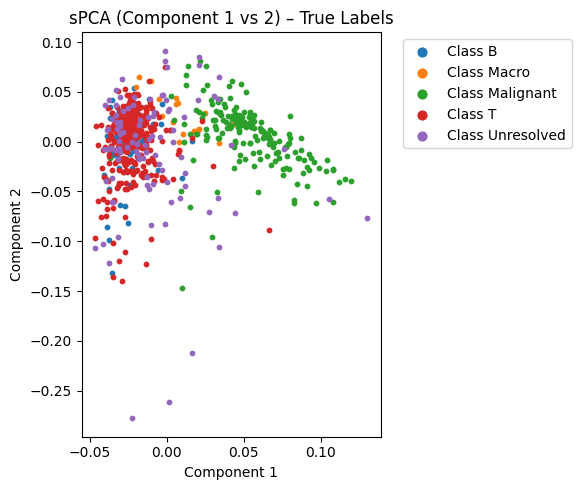

In [ ]:
# Scatterplot of first two sPCA components colored by true labels

plt.figure(figsize=(6, 5))
unique_lbls = np.unique(y_filtered)
for lbl in unique_lbls:
    idx = np.where(y_filtered == lbl)[0]
    plt.scatter(Q_spca[idx, 0], Q_spca[idx, 1], s=10, label=f"Class {lbl}")
plt.title("sPCA (Component 1 vs 2) – True Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## PCA

In [ ]:
## Now run the same analysis for PCA model.
k = len(np.unique(y_filtered))
PDM  = pca_torch(X_norm,k)
PDM = np.asarray(PDM)  # ensuring it is a NumPy array

# Compute the transformation matrix TM = (PDM^T PDM)^{-1} PDM^T
TM = np.linalg.inv(PDM.T @ PDM) @ PDM.T

# Project each cell (columns of X_scaled) onto the PCA subspace:
Q_pca = X_norm @ TM.T


In [ ]:
# Running KMeans on the PCA‐reduced data (Q_pca); computing ARI, NMI, ECS

ARI_vals, NMI_vals, ECS_vals = computeKMeans(Q_pca, y_filtered, max_state=30)

ARI_mean = ARI_vals.mean()
NMI_mean = NMI_vals.mean()
ECS_mean = ECS_vals.mean()

print("=== PCA + KMeans Clustering Results ===")
print(f"Number of clusters (k): {k}")
print(f"PCA projection shape: {Q_pca.shape}")
print(f"Adjusted Rand Index (mean over 30 inits): {ARI_mean:.4f}")
print(f"Normalized Mutual Info (mean over 30 inits): {NMI_mean:.4f}")
print(f"Element-Centric Score (mean over 30 inits): {ECS_mean:.4f}")

=== PCA + KMeans Clustering Results ===
Number of clusters (k): 5
PCA projection shape: (677, 5)
Adjusted Rand Index (mean over 30 inits): 0.4355
Normalized Mutual Info (mean over 30 inits): 0.4695
Element-Centric Score (mean over 30 inits): 0.5100


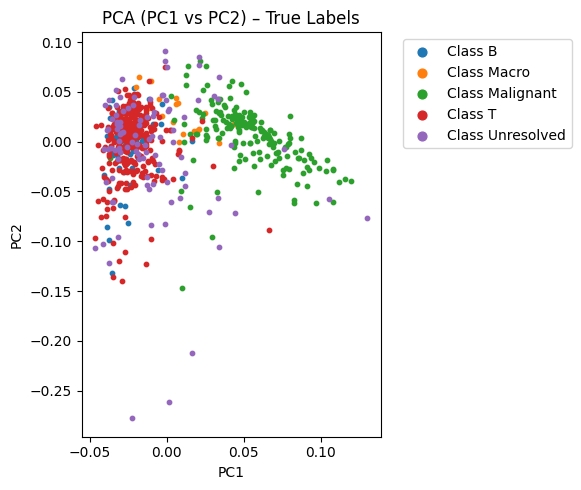

In [ ]:
plt.figure(figsize=(6, 5))
unique_lbls = np.unique(y_filtered)
for lbl in unique_lbls:
    idx = np.where(y_filtered == lbl)[0]
    plt.scatter(Q_pca[idx, 0], Q_pca[idx, 1], s=10, label=f"Class {lbl}")
plt.title("PCA (PC1 vs PC2) – True Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## visualization of the kNN-tPCA embedding matrix

In [ ]:
## Running heatmap on tPCA-Transformed Matrix
RpLSPCA_KNN_ari_mean = 0
RpLSPCA_KNN_nmi_mean = 0

beta  = 60
gamma = 100000.0
zeta = np.array([1.0, 0.5, 0.3333333, 0.25, 0.20, 0.16666667, 0.14285714, 0.125])
k = np.unique(y_filtered).shape[0]

PDM_t = RpLSPCA_cal_projections_KNN(X_norm, 60.0, 100000.0, 8, 15, zeta)
PDM_t = np.asarray(PDM_t)
TM  = np.linalg.inv(PDM_t.T @ PDM_t) @ (PDM_t.T)

Text(50.722222222222214, 0.5, 'Cells')

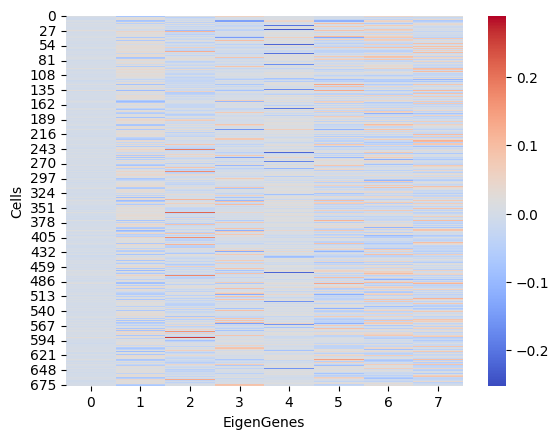

In [ ]:
Q_tPCA = X_norm @ TM.T
ax = sns.heatmap(Q_tPCA , annot=False, cmap="coolwarm", cbar=True)
ax.set_xlabel('EigenGenes')
ax.set_ylabel('Cells')